## Runs DE on different clusters. Also runs DE within each cluster for each condition.
Does this over each donor and combined

In [1]:
# Input info
se_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/SE.rds"
sample_names = "preB,postB"
outdir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/peaks_donors_DE_minPct_00_pval0.1"

# Parameters
assay="ATAC"
minPct = 0.00
logfcthresh = 0.25
top_de = 3
p_thresh=0.1
test.use="LR"
latent.vars = "peak_region_fragments"

# Parallel processing
cores = 4

# R utils script
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"



In [2]:
source(utils_script)
outdir = outdir
dir.create(outdir, showWarnings = FALSE)

btwnConds_inClust_sepDonrs.outdir <- file.path(outdir, "btwnConds_inClust_sepDonrs")
dir.create(btwnConds_inClust_sepDonrs.outdir)

btwnConds_inClust.outdir <- file.path(outdir, "btwnConds_inClust")
dir.create(btwnConds_inClust.outdir, showWarnings = FALSE)

Attaching SeuratObject



In [3]:
sample_names <- unlist(strsplit(sample_names, ",")[[1]])
sample_names

[1] "preB"  "postB"

In [4]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")

library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

Lo

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [5]:
se <- readRDS(se_f)#file.path(indir, paste0("allSamples.integrated.rds")))
DefaultAssay(se) <- assay
se

An object of class Seurat 
62328 features across 3683 samples within 2 assays 
Active assay: ATAC (42318 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap

## Run DE for  cluster vs all others 

In [6]:
btwnClust.outdir <- file.path(outdir, "btwnClust")
dir.create(btwnClust.outdir)


[1] "cluster 0"
                                p_val avg_log2FC pct.1 pct.2    p_val_adj
chr17-82126354-82128111  3.575789e-44  0.5283804 0.416 0.209 1.513203e-39
chr19-16368699-16370559  6.937084e-40  0.4883807 0.379 0.203 2.935635e-35
chr2-113876405-113877287 2.684604e-37  0.5642470 0.238 0.083 1.136071e-32
chr10-62183251-62184119  4.848188e-36  0.5622197 0.290 0.115 2.051656e-31
chr13-73984798-73985553  1.588710e-35  0.5670805 0.217 0.072 6.723104e-31
chr6-167112729-167114887 1.458550e-31 -0.5423227 0.004 0.134 6.172291e-27
                         p_val_adj_BH
chr17-82126354-82128111  4.848770e-41
chr19-16368699-16370559  4.703343e-37
chr2-113876405-113877287 1.213441e-34
chr10-62183251-62184119  1.643536e-33
chr13-73984798-73985553  4.308582e-33
chr6-167112729-167114887 3.296323e-29
[1] "saved cluster 0"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 1"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


                                 p_val avg_log2FC pct.1 pct.2     p_val_adj
chr2-231671303-231673284 3.968143e-193   1.385009 0.445 0.008 1.679239e-188
chr8-28338153-28339922   1.501393e-175   1.346467 0.407 0.006 6.353593e-171
chr6-167112729-167114887 4.323968e-167   1.325892 0.505 0.033 1.829817e-162
chr11-95715548-95716381  2.485687e-166   1.328892 0.389 0.006 1.051893e-161
chr6-90375476-90376336   1.541564e-159   1.303589 0.386 0.008 6.523591e-155
chr6-150622744-150623762 9.041613e-159   1.311871 0.423 0.016 3.826230e-154
                          p_val_adj_BH
chr2-231671303-231673284 2.334855e-189
chr8-28338153-28339922   4.417097e-172
chr6-167112729-167114887 8.480742e-164
chr11-95715548-95716381  3.656446e-163
chr6-90375476-90376336   1.814113e-156
chr6-150622744-150623762 8.866809e-156
[1] "saved cluster 1"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 2"
                                p_val avg_log2FC pct.1 pct.2    p_val_adj
chr11-65421105-65428554  2.492166e-18 -0.5350201 0.153 0.454 1.054635e-13
chr19-54189076-54191614  1.246387e-13 -0.3458012 0.355 0.659 5.274462e-09
chr11-62839312-62842762  9.073564e-13 -0.4068831 0.235 0.527 3.839751e-08
chr7-100368209-100370006 3.129736e-12 -0.4415726 0.006 0.110 1.324442e-07
chr16-21359908-21360687  1.380629e-11 -0.3701061 0.000 0.074 5.842548e-07
chr17-43360192-43362202  1.407813e-11 -0.4009268 0.219 0.478 5.957583e-07
                         p_val_adj_BH
chr11-65421105-65428554  4.463470e-15
chr19-54189076-54191614  1.116140e-10
chr11-62839312-62842762  5.416917e-10
chr7-100368209-100370006 1.401339e-09
chr16-21359908-21360687  4.202322e-09
chr17-43360192-43362202  4.202322e-09
[1] "saved cluster 2"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 3"
                               p_val avg_log2FC pct.1 pct.2    p_val_adj
chr2-86785367-86786744  2.745582e-67  0.9392968 0.359 0.057 1.161876e-62
chr12-10554115-10555430 3.336730e-63  0.9229451 0.254 0.023 1.412037e-58
chr2-86825722-86826746  8.772516e-39  0.7301453 0.214 0.034 3.712353e-34
chr12-1277791-1278375   1.939151e-34  0.6866591 0.169 0.022 8.206100e-30
chr17-82126354-82128111 1.501842e-33  0.5720396 0.506 0.214 6.355494e-29
chr20-53388212-53388745 1.974605e-30  0.6431213 0.145 0.017 8.356134e-26
                        p_val_adj_BH
chr2-86785367-86786744  2.333745e-64
chr12-10554115-10555430 1.418110e-60
chr2-86825722-86826746  2.485546e-36
chr12-1277791-1278375   4.120696e-32
chr17-82126354-82128111 2.553131e-31
chr20-53388212-53388745 2.797357e-28
[1] "saved cluster 3"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 4"
                                p_val avg_log2FC pct.1 pct.2    p_val_adj
chr10-33133999-33134689  2.858396e-27  0.6919971 0.170 0.021 1.209616e-22
chr14-64755813-64756297  2.936822e-24  0.6337633 0.136 0.016 1.242804e-19
chr11-3512069-3512652    1.828216e-23  0.6521940 0.153 0.021 7.736646e-19
chr10-12448584-12449524  2.962826e-23  0.6311979 0.303 0.094 1.253809e-18
chr1-184890397-184891007 5.001657e-22  0.6147197 0.150 0.023 2.116601e-17
chr5-912337-912980       1.552716e-21  0.5804562 0.113 0.011 6.570783e-17
                         p_val_adj_BH
chr10-33133999-33134689  2.861255e-24
chr14-64755813-64756297  1.469879e-21
chr11-3512069-3512652    6.100149e-21
chr10-12448584-12449524  7.414473e-21
chr1-184890397-184891007 1.001332e-19
chr5-912337-912980       2.590448e-19
[1] "saved cluster 4"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 5"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                                 p_val avg_log2FC pct.1 pct.2     p_val_adj
chr14-50038437-50039238  1.063145e-145   1.691428 0.525 0.004 4.499015e-141
chr6-44058393-44059510   3.452702e-126   1.586568 0.459 0.003 1.461114e-121
chr10-30493460-30494630  1.320881e-123   1.596473 0.514 0.011 5.589703e-119
chr2-47071386-47073302   1.661673e-112   1.537753 0.553 0.023 7.031867e-108
chr7-157854043-157854781 5.239850e-112   1.505823 0.400 0.002 2.217400e-107
chr1-234656954-234657607 9.559206e-110   1.483691 0.396 0.002 4.045265e-105
                          p_val_adj_BH
chr14-50038437-50039238  9.729900e-142
chr6-44058393-44059510   1.579956e-122
chr10-30493460-30494630  4.029567e-120
chr2-47071386-47073302   3.801907e-109
chr7-157854043-157854781 9.591022e-109
chr1-234656954-234657607 1.458098e-106
[1] "saved cluster 5"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 6"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


                                p_val avg_log2FC pct.1 pct.2    p_val_adj
chr22-23263712-23264504  1.314475e-65   1.232253 0.365 0.025 5.562597e-61
chr4-8409163-8410086     1.798201e-64   1.215013 0.454 0.048 7.609628e-60
chr12-52566659-52567503  1.472772e-57   1.177770 0.345 0.026 6.232476e-53
chr1-184386663-184388161 2.753523e-56   1.133881 0.414 0.051 1.165236e-51
chr7-38317398-38317995   3.517722e-55   1.106524 0.257 0.010 1.488629e-50
chr20-20215992-20216709  1.017342e-53   1.127317 0.269 0.012 4.305188e-49
                         p_val_adj_BH
chr22-23263712-23264504  4.194491e-62
chr4-8409163-8410086     2.869030e-61
chr12-52566659-52567503  1.566538e-54
chr1-184386663-184388161 2.196623e-53
chr7-38317398-38317995   2.245010e-52
chr20-20215992-20216709  5.410563e-51
[1] "saved cluster 6"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 7"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


                                p_val avg_log2FC pct.1 pct.2    p_val_adj
chr12-52566659-52567503  3.982381e-50   1.290860 0.402 0.030 1.685264e-45
chr4-8409163-8410086     1.501373e-44   1.191097 0.448 0.057 6.353512e-40
chr18-80175191-80175964  3.278908e-42   1.198393 0.333 0.021 1.387568e-37
chr6-105646199-105646957 4.656025e-38   1.139736 0.310 0.023 1.970336e-33
chr5-76732655-76733463   1.446934e-37   1.123893 0.264 0.014 6.123136e-33
chr16-81524162-81524889  9.109619e-34   1.075160 0.299 0.029 3.855008e-29
                         p_val_adj_BH
chr12-52566659-52567503  1.295469e-46
chr4-8409163-8410086     2.441984e-41
chr18-80175191-80175964  3.555429e-39
chr6-105646199-105646957 3.786512e-35
chr5-76732655-76733463   9.413754e-35
chr16-81524162-81524889  4.938932e-31
[1] "saved cluster 7"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 8"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                                p_val avg_log2FC pct.1 pct.2    p_val_adj
chr8-20492848-20493801   2.574908e-21  0.8277389 0.486 0.102 1.089650e-16
chr5-134086628-134087518 2.522097e-18  0.8464473 0.500 0.102 1.067301e-13
chr1-234408652-234409669 1.786493e-16  0.7812182 0.295 0.046 7.560080e-12
chr17-75036499-75037218  7.218060e-15  0.7297646 0.486 0.121 3.054539e-10
chr3-168094682-168096524 1.447014e-14 -0.4216686 0.021 0.122 6.123473e-10
chr16-10876628-10877426  4.706455e-14 -0.3687307 0.014 0.094 1.991678e-09
                         p_val_adj_BH
chr8-20492848-20493801   3.014960e-17
chr5-134086628-134087518 1.476562e-14
chr1-234408652-234409669 6.972681e-13
chr17-75036499-75037218  2.112907e-11
chr3-168094682-168096524 3.388617e-11
chr16-10876628-10877426  9.184647e-11
[1] "saved cluster 8"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 9"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


                                 p_val avg_log2FC pct.1 pct.2    p_val_adj
chr11-114065915-114066565 1.050385e-33   1.217791 0.300 0.014 4.445020e-29
chr14-101712854-101714002 2.216015e-31   1.186661 0.354 0.030 9.377734e-27
chr2-9702879-9703855      9.088069e-31   1.132313 0.454 0.066 3.845889e-26
chr15-58209172-58209531   3.973224e-30   1.104149 0.208 0.004 1.681389e-25
chr17-82909333-82909909   1.012096e-28   1.134250 0.269 0.014 4.282987e-24
chr1-57307250-57307908    5.555704e-28   1.126203 0.331 0.030 2.351063e-23
                          p_val_adj_BH
chr11-114065915-114066565 3.055570e-30
chr14-101712854-101714002 3.223195e-28
chr2-9702879-9703855      8.812397e-28
chr15-58209172-58209531   2.889527e-27
chr17-82909333-82909909   5.888373e-26
chr1-57307250-57307908    2.693591e-25
[1] "saved cluster 9"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 10"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

                                p_val avg_log2FC pct.1 pct.2    p_val_adj
chr7-101717697-101718358 1.059849e-18   2.047556 0.684 0.017 4.485068e-14
chr16-17591224-17591484  9.710740e-14   1.836357 0.474 0.009 4.109391e-09
chr1-182149248-182149857 2.073881e-13   1.762900 0.579 0.028 8.776252e-09
chr12-64699708-64700081  2.556225e-12   1.733862 0.474 0.013 1.081743e-07
chr20-4829544-4829899    6.750703e-12   1.703218 0.474 0.014 2.856762e-07
chr2-145693061-145693505 7.364654e-11   1.618546 0.474 0.018 3.116574e-06
                         p_val_adj_BH
chr7-101717697-101718358 1.230590e-14
chr16-17591224-17591484  5.637570e-10
chr1-182149248-182149857 8.026612e-10
chr12-64699708-64700081  7.420081e-09
chr20-4829544-4829899    1.567648e-08
chr2-145693061-145693505 1.093688e-07
[1] "saved cluster 10"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



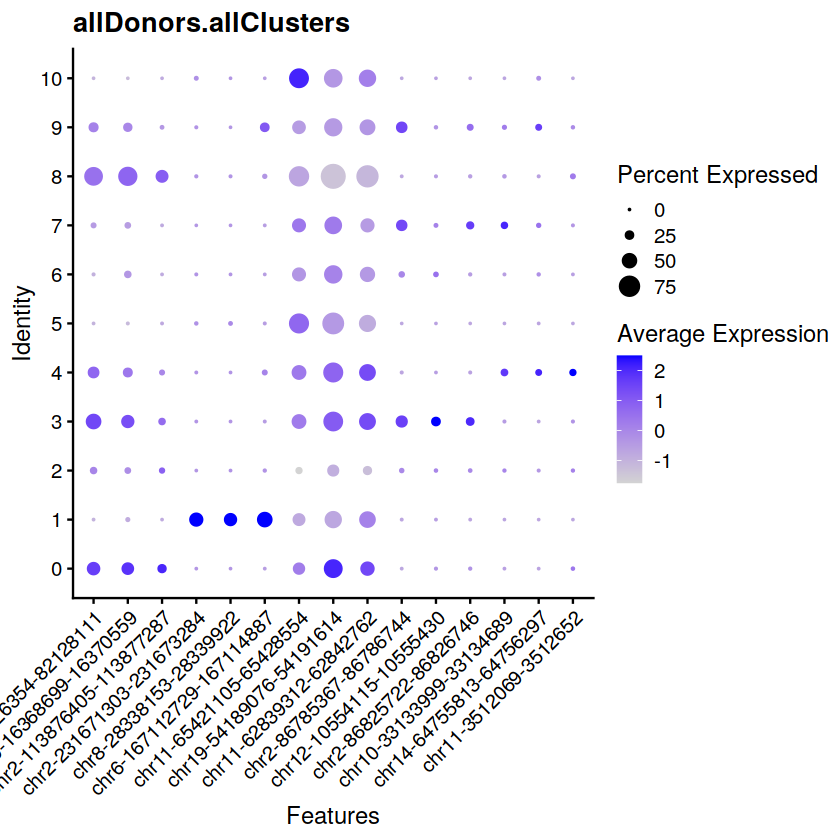

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



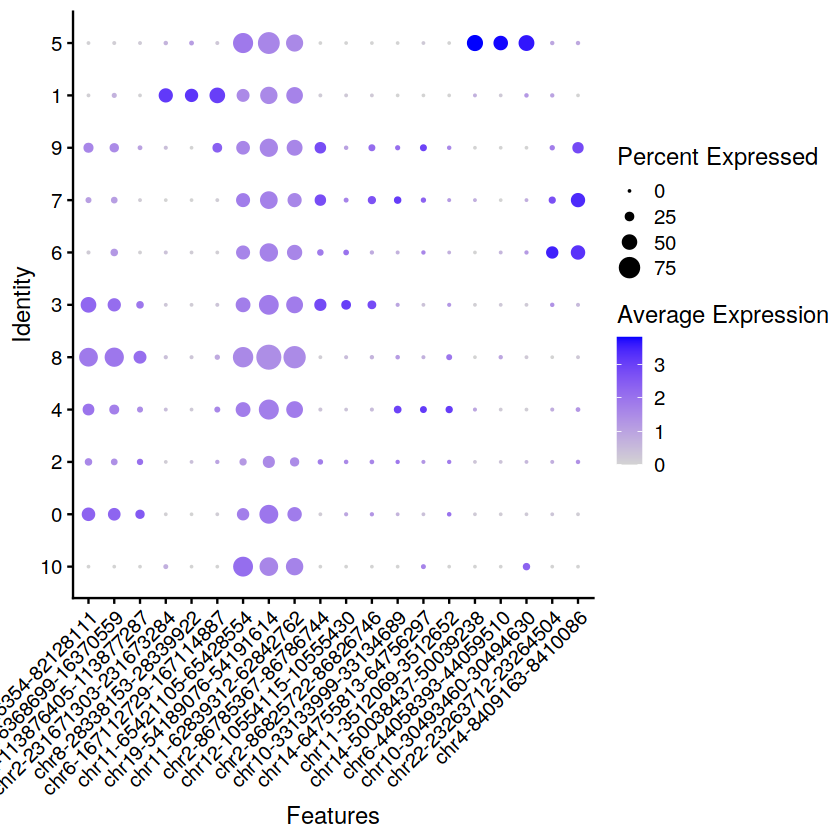

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



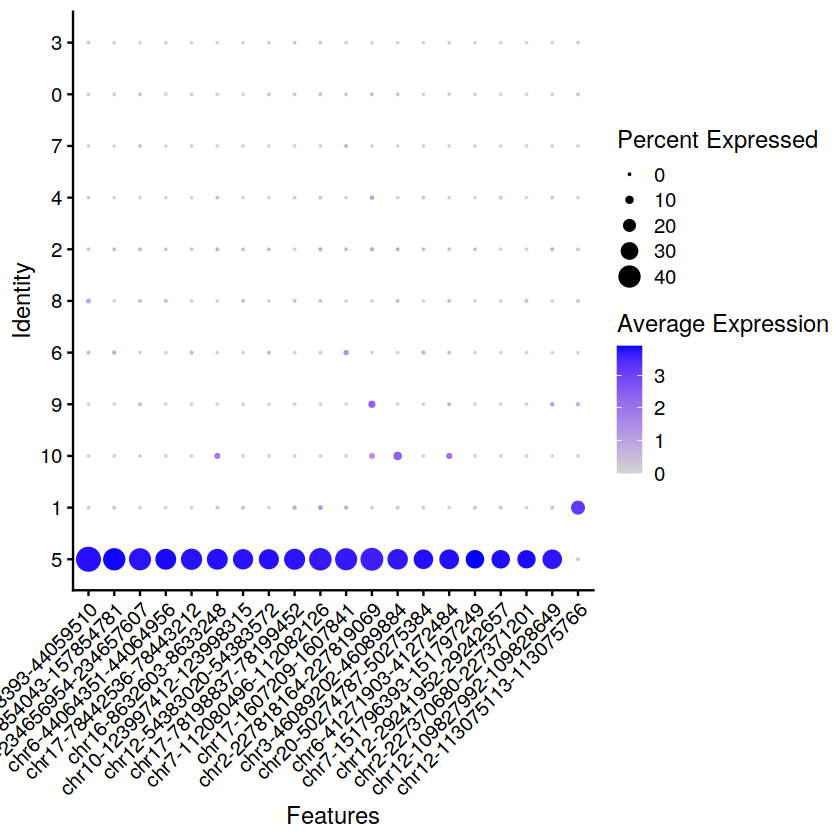

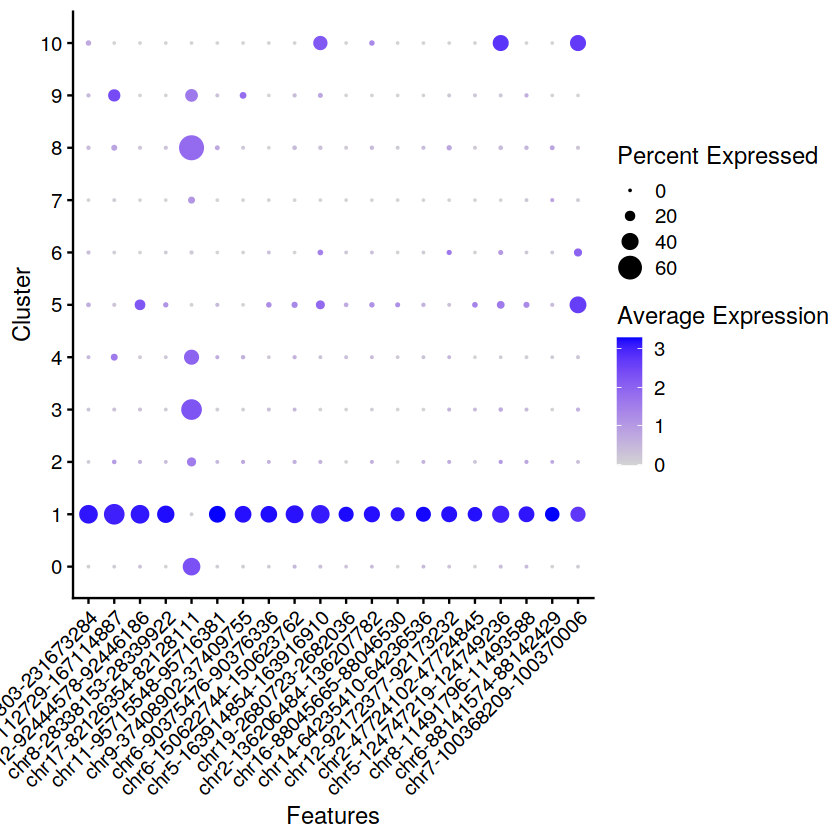

In [7]:
curr.outdir <- btwnClust.outdir

cluster.ids <- sort(unique(se$seurat_clusters))
Idents(se) <- se$seurat_clusters

all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
all.names.sig <- c()
for (id1 in cluster.ids){ #or however many clusters you have
    try({
        print(paste("cluster", id1))
        response <- FindMarkers(
                      object = se,
                      ident.1 = id1, #"CD4 Naive",
                      min.pct = minPct,
                      test.use = test.use, latent.vars = latent.vars
                    )
        response$p_val_adj_BH <- stats::p.adjust(response$p_val, method = "BH", n = length(response$p_val)) 
        response <- response %>% dplyr::arrange(p_val_adj_BH)
        print(head(response))
        #write.csv(response, file=file.path(clust_outdir, paste0("cluster_",i,"vsAll.DE.csv")))
        curr.sig <- response %>% dplyr::filter(p_val_adj_BH<p_thresh)
        names.sig <- rownames(curr.sig)
        #se <- subset(se, seurat_clusters == id1)

        
 
        if (assay == "ATAC"){
            print("ATAC")
            response.features <- ClosestFeature(se, regions = rownames(response))
            response.features = response.features %>% dplyr::mutate(gene.id = paste(gene_name,type, sep="_"))
            response$gene.id = response.features$gene.id
            feature.names.sig <- response[names.sig, "gene.id"]
        }else{
            feature.names.sig <- names.sig
        }
        write.csv(response,
                  file=file.path(curr.outdir, paste0("cluster",id1,".DE.csv")), quote=F)
        
        de.plots(se, names.sig, curr.outdir, curr.name=id1, max.size=10, to.heat=T,to.vln=T, 
                 feature.names=feature.names.sig)
        print(paste('saved cluster', id1))
        
        # Add to all pvals
        all.names.sig <- c(all.names.sig, head(names.sig, top_de))
        all.pvals[names.sig,id1] <- curr.sig$p_val_adj_BH

    })
}


all.names.sig <- unique(all.names.sig)
de.plots(se, all.names.sig, curr.outdir, curr.name="allDonors.allClusters", max.size=15)

dot <- DotPlot(se, scale=FALSE,
               features = head(all.names.sig,20), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(curr.outdir, "allClusters.top3de.png"))
ggsave(file.path(curr.outdir, "allClusters.top3de.pdf"))

## b) averaged top p-values (only average ones that were DE)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=F,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(curr.outdir, "allClusters.pvalsOrdered.scaleF.png"))
ggsave(file.path(curr.outdir, "allClusters.pvalsOrdered.scaleF.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)



all.pvals.nafill <- all.pvals
all.pvals.nafill[,] <- -log10(zoo::na.fill(all.pvals,1))

sig.all.ordered <- sort(rowMeans(all.pvals.nafill), decreasing=T)
dot <- DotPlot(se, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Cluster")
ggsave(file.path(btwnClust.outdir,
                 "allClusters.ovalsOrderedNA.scaleF.png"))
ggsave(file.path(btwnClust.outdir,
                 "allClusters.ovalsOrderedNA.scaleF.pdf"))
dot

In [8]:
all.names.sig

[1] "chr17-82126354-82128111"   "chr19-16368699-16370559"  
 [3] "chr2-113876405-113877287"  "chr2-231671303-231673284" 
 [5] "chr8-28338153-28339922"    "chr6-167112729-167114887" 
 [7] "chr11-65421105-65428554"   "chr19-54189076-54191614"  
 [9] "chr11-62839312-62842762"   "chr2-86785367-86786744"   
[11] "chr12-10554115-10555430"   "chr2-86825722-86826746"   
[13] "chr10-33133999-33134689"   "chr14-64755813-64756297"  
[15] "chr11-3512069-3512652"     "chr14-50038437-50039238"  
[17] "chr6-44058393-44059510"    "chr10-30493460-30494630"  
[19] "chr22-23263712-23264504"   "chr4-8409163-8410086"     
[21] "chr12-52566659-52567503"   "chr18-80175191-80175964"  
[23] "chr8-20492848-20493801"    "chr5-134086628-134087518" 
[25] "chr1-234408652-234409669"  "chr11-114065915-114066565"
[27] "chr14-101712854-101714002" "chr2-9702879-9703855"     
[29] "chr7-101717697-101718358"  "chr16-17591224-17591484"  
[31] "chr1-182149248-182149857"

In [9]:
gene.maps <- ClosestFeature(se, all.names.sig)
gene.maps <- gene.maps %>% dplyr::mutate(gene.id=paste0(gene_name, "_", type))
rownames(gene.maps) <- all.names.sig
gene.maps

,tx_id,gene_name,gene_id,gene_biotype,type,closest_region,query_region,distance,gene.id
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<int>,<chr>
chr17-82126354-82128111,ENST00000570366,AC139099.5,ENSG00000262094,lincRNA,exon,chr17-81175418-81175490,chr17-82126354-82128111,950863,AC139099.5_exon
chr19-16368699-16370559,ENST00000291439,AP1M1,ENSG00000072958,protein_coding,utr,chr19-16345247-16346160,chr19-16368699-16370559,22538,AP1M1_utr
chr2-113876405-113877287,ENST00000486167,IL1RN,ENSG00000136689,protein_coding,gap,chr2-113875606-113885265,chr2-113876405-113877287,0,IL1RN_gap
chr2-231671303-231673284,ENST00000410084,CAB39,ENSG00000135932,protein_coding,gap,chr2-231663613-231674977,chr2-231671303-231673284,0,CAB39_gap
chr8-28338153-28339922,ENST00000521548,FBXO16,ENSG00000214050,protein_coding,gap,chr8-28331325-28340864,chr8-28338153-28339922,0,FBXO16_gap
chr6-167112729-167114887,ENST00000512860,RPS6KA2,ENSG00000071242,protein_coding,gap,chr6-166952273-167319845,chr6-167112729-167114887,0,RPS6KA2_gap
chr11-65421105-65428554,ENST00000534558,RELA,ENSG00000173039,protein_coding,cds,chr11-65427595-65427686,chr11-65421105-65428554,0,RELA_cds
chr19-54189076-54191614,ENST00000376650,DPRX,ENSG00000204595,protein_coding,utr,chr19-54140243-54140263,chr19-54189076-54191614,48812,DPRX_utr
chr11-62839312-62842762,ENST00000417740,SLC22A24,ENSG00000197658,protein_coding,cds,chr11-62847412-62847469,chr11-62839312-62842762,4649,SLC22A24_cds


In [10]:
btwn_embeddings <- file.path(btwnClust.outdir, "embeddings")
dir.create(btwn_embeddings)

featplot <- function(name.sig, se, curr.outdir, maps=NULL){
    feat <- FeaturePlot(se,  features=name.sig)
    name <- name.sig
    if (!is.null(maps)){
        name <- maps[name.sig, "gene.id"]
        feat <- feat + ggtitle(name)
    }
    ggsave(plot=feat,
           file=file.path(curr.outdir, paste0(name,".embedFeat.top3.png")))
    }

sapply(all.names.sig[1:20], FUN=featplot, se=se, curr.outdir=btwn_embeddings, maps=gene.maps)

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



chr17-82126354-82128111 
   "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/peaks_donors_DE_minPct_00_pval0.1/btwnClust/embeddings/AC139099.5_exon.embedFeat.top3.png" 
                                                                                                                                                                                                                                                                                                                                chr19-16368699-16370559 
         "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/peaks_donors_DE_minPct_00_pval0.1/btwnClust/embeddings/AP1M1_utr.embedFeat.top3.png" 
                                                                                                                                                                                                                                                                                                                               chr2-113876405-113877287 
         "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/peaks_donors_DE_minPct_00_pval0.1/btwnClust/embeddings/IL1RN_gap.embedFeat.top3.png" 
                                                                                                                                                                                                                                                                                                                               chr2-231671303-231673284 
         "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/peaks_donors_DE_minPct_00_pval0.1/btwnClust/embeddings/CAB39_gap.embedFeat.top3.png" 
                                                                                                                                                                                                                                                                                                                                 chr8-28338153-28339922 
        "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/peaks_donors_DE_minPct_00_pval0.1/btwnClust/embeddings/FBXO16_gap.embedFeat.top3.png" 
                                                                                                                                                                                                                                                                                                                               chr6-167112729-167114887 
       "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/peaks_donors_DE_minPct_00_pval0.1/btwnClust/embeddings/RPS6KA2_gap.embedFeat.top3.png" 
                                                                                                                                                                                    

## Separate by donor

In [11]:
# btwnClust.sepDons.outdir <- file.path(outdir, "btwnClust_sepDons")
# dir.create(btwnClust.sepDons.outdir)
# curr.outdir <- btwnClust.sepDons.outdir

# # Setup Idents to include the condition, clusters and donor
# se$clust_donor <- as.factor(apply(se[[]][ , c( "seurat_clusters", "donor") ] , 1 , paste , collapse = "_" ))
# Idents(se) <- se$clust_donor
# don.ids <- levels(se$donor)
# cluster.ids <- sort(unique(se$seurat_clusters))

# all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
#                           row.names=row.names(se))
# all.names.sig <- c()

# for (clust in cluster.ids){ #or however many clusters you have
#     clust.names.sig <- c()
#     print("cluster")
#     print(clust)
#     clust.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
#                               row.names=row.names(se))
#     clust.outdir <- file.path(curr.outdir, paste0("clust", clust))
#     dir.create(clust.outdir)
#     for (don in don.ids){
#         try({
#             if (clust == "None" | don == "None"){
#                 print("clust or don is none")
#                 next
#             }
#             id1 = paste0(clust, "_", don)
#             print("ID1")
#             print(id1)
#             response <- FindMarkers(
#                           object = se,
#                           ident.1 = id1, #"CD4 Naive",
#                           min.pct = minPct,
#                           test.use = 'wilcox', latent.vars = NULL
#                         )
            
#             #write.csv(response, file=file.path(clust_outdir, paste0("cluster_",i,"vsAll.DE.csv")))
#             response <- response %>% dplyr::arrange(p_val)
#             response$p_val_adj_BH <- stats::p.adjust(response$p_val, method = "BH", n = length(response$p_val))    
#             print(head(response))            
#             write.csv(response,
#                       file=file.path(clust.outdir, paste0("clust",clust,"donor", don, ".DE.csv")), quote=F)
            
#             curr.sig <- response %>% dplyr::filter(p_val_adj_BH<p_thresh)
#             names.sig <- rownames(curr.sig)
#             se.filt <- subset(se, idents = id1)
#             de.plots(se.filt, names.sig, clust.outdir, curr.name=id1, max.size=10, to.heat=T,to.vln=T)
            
#             # Add to all pvals
#             all.names.sig <- c(all.names.sig, head(names.sig, top_de))
#             all.pvals[names.sig,id1] <- curr.sig$p_val_adj_BH
#             clust.names.sig <- c(clust.names.sig, head(names.sig, top_de))
#             clust.pvals[names.sig, don] <- curr.sig$p_val_adj_BH
#         })
#     }
#     if (clust != "None"){
#         se.filt <- subset(se, subset = seurat_clusters == clust & donor != "None")
#         Idents(se.filt) <- se.filt$donor
#         wrap.plot.over.all(se.filt, clust.outdir, clust.pvals, clust.names.sig, 
#                            name=paste0("cluster",clust,"topDonorDE.split_donors"))
#     }
# }

# wrap.plot.over.all(se, curr.outdir, all.pvals, all.names.sig, name="allClusters")
